In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/Netflix')

## Step 1: Preparing Data

In [ ]:
start_count = [1, 4500, 9211, 13368]
end_count = [4499, 9210, 13367, 17770]

In [ ]:
def whole_processor(file_num):
  filename = f"combined_data_{file_num}.txt"
  df = pd.read_csv(filename, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
  df['Rating'] = df['Rating'].astype(float)

  movie_idx = df[df['Rating'].isnull()].index

  empty_list = []
  df['Movie_Number'] = np.append(empty_list, np.repeat(np.nan, len(df)))

  timeA = time.time()
  movie_count = start_count[file_num-1]
  tmp_list = []
  for i in range(len(movie_idx)-1):
    start_idx = movie_idx[i]
    end_idx = movie_idx[i+1]
    df.loc[start_idx:end_idx,'Movie_Number'] = np.repeat(movie_count, end_idx - start_idx + 1)
    movie_count += 1

  df.loc[movie_idx[-1]:,'Movie_Number'] = end_count[file_num-1]

  final_df = df[df['Rating'].notna()]
  save_filename = f"{start_count[file_num-1]}_to_{end_count[file_num-1]}.csv"
  final_df.to_csv(save_filename,index=False)
  timeB = time.time()
  print("Running time:", (timeB - timeA) / 60)
  return final_df

In [ ]:
df1 = pd.read_csv('0_to_4499.csv')
df2 = pd.read_csv('4500_to_9210.csv')
df3 = pd.read_csv('9211_to_13367.csv')
df4 = pd.read_csv('13368_to_17770.csv')

In [ ]:
all_df = pd.concat([df1,df2,df3,df4])
all_df

,Cust_Id,Rating,Movie_Number
0,1488844,3.0,1.0
1,822109,5.0,1.0
2,885013,4.0,1.0
3,30878,4.0,1.0
4,823519,3.0,1.0
...,...,...,...
26847518,1790158,4.0,17770.0
26847519,1608708,3.0,17770.0
26847520,234275,1.0,17770.0
26847521,255278,4.0,17770.0


## Step 2: Subsetting Data

In [ ]:
# Code from https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation
# Extract Top 500 popular movies

f = ['count','mean']

df_movie_summary = all_df.groupby('Movie_Number')['Rating'].agg(f).sort_values(by=['count'], ascending = False)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = df_movie_summary['count'][:500].min()
movie_benchmark
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 37995


In [ ]:
# Extract Top 1000 Ardent Users

df_cust_summary = all_df.groupby('Cust_Id')['Rating'].agg(f).sort_values(by=['count'], ascending = False)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = df_cust_summary['count'][:1000].min() #round(df_cust_summary['count'].quantile(0.995),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 2087


In [ ]:
rating_df = df.pivot_table(index=['Cust_Id'], columns='Movie_Number', values='Rating')
rating_df = pd.DataFrame(rating_df.to_records())
rating_df

,Cust_Id,28.0,30.0,143.0,175.0,191.0,197.0,241.0,290.0,299.0,...,17479.0,17482.0,17506.0,17508.0,17560.0,17621.0,17622.0,17627.0,17709.0,17764.0
0,1333,2.0,3.0,4.0,3.0,1.0,2.0,3.0,4.0,1.0,...,2.0,2.0,NaN,1.0,NaN,NaN,3.0,2.0,3.0,4.0
1,3321,4.0,5.0,3.0,NaN,4.0,NaN,NaN,4.0,4.0,...,4.0,4.0,2.0,NaN,4.0,NaN,2.0,4.0,4.0,5.0
2,3998,5.0,5.0,4.0,NaN,5.0,5.0,5.0,5.0,5.0,...,5.0,4.0,NaN,NaN,5.0,4.0,5.0,5.0,NaN,5.0
3,5980,NaN,5.0,3.0,3.0,NaN,NaN,NaN,5.0,NaN,...,5.0,NaN,5.0,5.0,3.0,NaN,4.0,5.0,NaN,5.0
4,10268,NaN,3.0,4.0,4.0,4.0,4.0,3.0,NaN,3.0,...,3.0,NaN,NaN,3.0,4.0,4.0,4.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2637886,5.0,5.0,5.0,2.0,4.0,NaN,NaN,5.0,5.0,...,3.0,3.0,NaN,4.0,5.0,3.0,2.0,5.0,5.0,5.0
997,2640278,3.0,NaN,4.0,5.0,5.0,NaN,NaN,5.0,NaN,...,3.0,NaN,NaN,4.0,4.0,4.0,4.0,NaN,3.0,3.0
998,2640550,4.0,5.0,4.0,2.0,4.0,5.0,NaN,4.0,5.0,...,4.0,3.0,5.0,NaN,3.0,NaN,3.0,5.0,4.0,4.0
999,2640760,3.0,3.0,4.0,5.0,4.0,NaN,5.0,4.0,3.0,...,4.0,4.0,NaN,4.0,4.0,4.0,NaN,4.0,NaN,3.0


In [ ]:
titles = pd.read_csv("movie_titles.csv", encoding = "unicode_escape", header = None).iloc[:,:3]
titles.columns = ["ID","year", "title"]
# titles

In [ ]:
raw_titles = [titles[titles["ID"] == float(movie_id)]["title"].values[0] for movie_id in rating_df.columns[1:]]
rating_df.columns = ["Cust_ID"] + raw_titles
# rating_df

## Step 3: Scaling

In [ ]:
scaled_df = rating_df.copy().iloc[:,1:]
averages = scaled_df.mean(axis=1).values
for i in range(len(rating_df)):
  # Subtract by mean of each user, not the entire user
  scaled_df.iloc[i,:] = (scaled_df.iloc[i,:] - averages[i]) 

scaled_df = scaled_df.fillna(0) # fillna(0) should come after scaling
scaled_df["Cust_ID"] = rating_df["Cust_ID"]
scaled_df = pd.concat([pd.DataFrame({"Cust_Id": scaled_df["Cust_ID"]}), scaled_df.iloc[:,1:]], axis = 1)
scaled_df

,Cust_Id,Something's Gotta Give,The Game,Reservoir Dogs,X2: X-Men United,Taking Lives,North by Northwest,Harold and Kumar Go to White Castle,Bridget Jones's Diary,High Fidelity,...,Clueless,Little Black Book,Requiem for a Dream,Ghostbusters,Tomorrow Never Dies,Vanilla Sky,Harry Potter and the Sorcerer's Stone,A River Runs Through It,Shakespeare in Love,Cust_ID
0,1333,0.309852,1.309852,0.309852,-1.690148,-0.690148,0.309852,1.309852,-1.690148,0.309852,...,-0.690148,0.000000,-1.690148,0.000000,0.000000,0.309852,-0.690148,0.309852,1.309852,1333
1,3321,1.156003,-0.843997,0.000000,0.156003,0.000000,0.000000,0.156003,0.156003,0.000000,...,0.156003,-1.843997,0.000000,0.156003,0.000000,-1.843997,0.156003,0.156003,1.156003,3321
2,3998,0.232747,-0.767253,0.000000,0.232747,0.232747,0.232747,0.232747,0.232747,0.232747,...,-0.767253,0.000000,0.000000,0.232747,-0.767253,0.232747,0.232747,0.000000,0.232747,3998
3,5980,1.023637,-0.976363,-0.976363,0.000000,0.000000,0.000000,1.023637,0.000000,-0.976363,...,0.000000,1.023637,1.023637,-0.976363,0.000000,0.023637,1.023637,0.000000,1.023637,5980
4,10268,-0.649250,0.350750,0.350750,0.350750,0.350750,-0.649250,0.000000,-0.649250,-0.649250,...,0.000000,0.000000,-0.649250,0.350750,0.350750,0.350750,-0.649250,0.350750,0.350750,10268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,2637886,1.321408,1.321408,-1.678592,0.321408,0.000000,0.000000,1.321408,1.321408,1.321408,...,-0.678592,0.000000,0.321408,1.321408,-0.678592,-1.678592,1.321408,1.321408,1.321408,2637886
997,2640278,0.000000,0.173423,1.173423,1.173423,0.000000,0.000000,1.173423,0.000000,1.173423,...,0.000000,0.000000,0.173423,0.173423,0.173423,0.173423,0.000000,-0.826577,-0.826577,2640278
998,2640550,1.254709,0.254709,-1.745291,0.254709,1.254709,0.000000,0.254709,1.254709,-0.745291,...,-0.745291,1.254709,0.000000,-0.745291,0.000000,-0.745291,1.254709,0.254709,0.254709,2640550
999,2640760,-0.484659,0.515341,1.515341,0.515341,0.000000,1.515341,0.515341,-0.484659,1.515341,...,0.515341,0.000000,0.515341,0.515341,0.515341,0.000000,0.515341,0.000000,-0.484659,2640760


## Step 2: Compare Similarities

In [ ]:
def indices(lst, item):
  return [i for i, x in enumerate(lst) if x == item]

In [ ]:
def return_similarity(current_rating, idx):
  similarity_list = []
  for i in range(len(scaled_df)):
      if i == idx:
        continue
      another_rating = np.array([scaled_df.iloc[i,1:]]) # rating of another 
      curr_similarity = round(cosine_similarity(current_rating, another_rating)[0][0], 3)
      similarity_list.append(curr_similarity)

  current_id = scaled_df.iloc[[idx]]["Cust_Id"].values[0]
  max_similarity = max(similarity_list)
  max_idx = similarity_list.index(max_similarity)
  target_id = scaled_df.iloc[[max_idx]]["Cust_Id"].values[0]

  return similarity_list

In [ ]:
list(map(lambda x: x + 3.5, [1.0, 2.0]))

[4.5, 5.5]

In [ ]:
def plot_rating(expected_dict, idx):
  title = expected_dict.keys()
  rating = expected_dict.values()
  recommended = []
  for score in rating:
    if score > 0:
      recommended.append(True)
    else:
      recommended.append(False)
  df = pd.DataFrame({"Title" : title, "Expected Rating": rating, "Recommended" : recommended}).sort_values(by = "Expected Rating", ascending = False)
  plt.figure(figsize=(20, 7))
  plt.xticks(rotation=90)
  plt.title("Predicted Rating for Unwatched Movies and Recommendation")
  return (sns.barplot(x = "Title", y = "Expected Rating", hue = "Recommended", data = df), df.iloc[:10,:])

In [ ]:
def get_similarity(idx):
  current_rating = np.array([scaled_df.iloc[idx,1:]]) # rating of the current user

  if 0 not in current_rating: # BASE CASE: if the user has watched all movies, then returns nothing.
    print("This user has watched all the movies.")
    return -1

  similarity_list = return_similarity(current_rating, idx)

  idx_count = 0
  ratings = current_rating[0].tolist()
  expected_dict = dict()
  for rating in ratings: 
    if rating != 0: # skip if the user has already seen a movie
      continue
    count = 0
    movie_idx = indices(ratings, rating)[idx_count] #ratings.index(rating)
    numerator = 0
    denominator = 0

    
    # print("Predicting movie:", raw_titles[movie_idx])
    idx_count += 1

    for j in range(len(scaled_df)):
      if j == idx: # don't add up my own rating
        continue
      other_rating = round(scaled_df.iloc[j,movie_idx+1],3)
      other_similarity = similarity_list[count]
      count += 1
      
      if other_rating == 0: # we do not consider the similarity of unwatched user because it only affects denominator, but not numerator
        continue

      # numerator is iteratively adding up each rating x each similarity score
      numerator = numerator + (other_rating * other_similarity)
      denominator += other_similarity

    if denominator == 0: # avoid zero division error
      expected_rating = 0
    else:
      expected_rating = round(numerator / denominator, 2)

    expected_dict[raw_titles[movie_idx]] = expected_rating

  return plot_rating(expected_dict, idx)

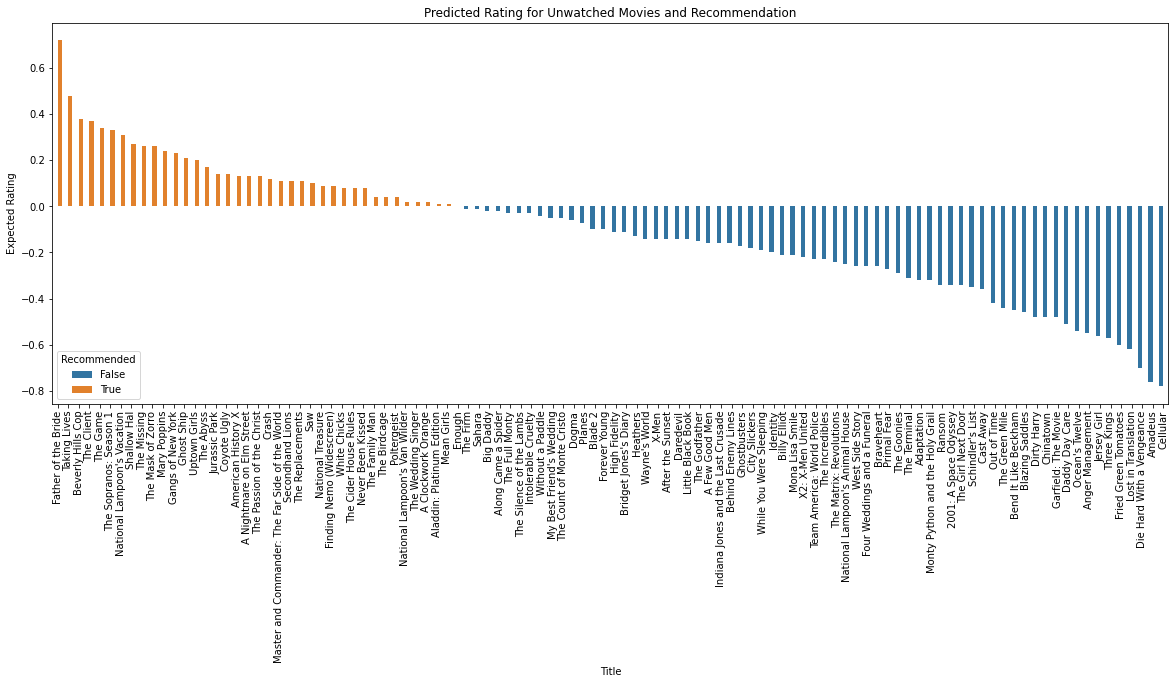

In [ ]:
res1 = get_similarity(1)

In [ ]:
res1[1]

,Title,Expected Rating,Recommended
89,Father of the Bride,0.72,True
2,Taking Lives,0.48,True
15,Beverly Hills Cop,0.38,True
70,The Client,0.37,True
0,The Game,0.34,True
90,The Sopranos: Season 1,0.33,True
11,National Lampoon's Vacation,0.31,True
38,Shallow Hal,0.27,True
22,The Missing,0.26,True
87,The Mask of Zorro,0.26,True


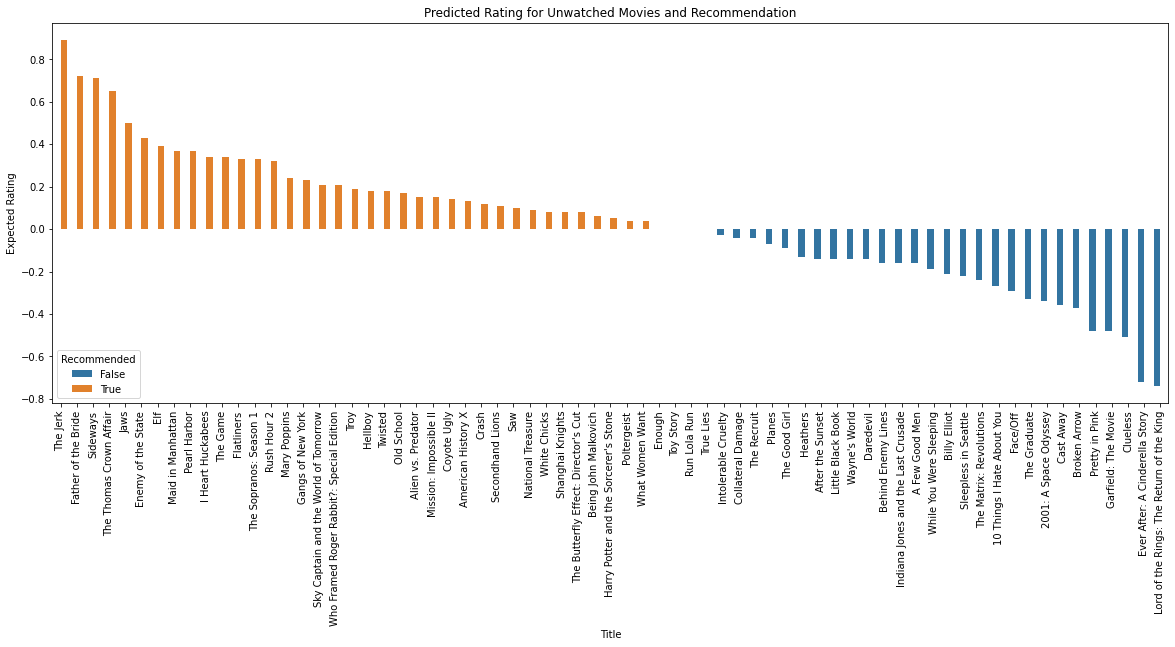

In [ ]:
res2 = get_similarity(2)

In [ ]:
res2[1]

,Title,Expected Rating,Recommended
34,The Jerk,0.89,True
56,Father of the Bride,0.72,True
17,Sideways,0.71,True
50,The Thomas Crown Affair,0.65,True
3,Jaws,0.50,True
45,Enemy of the State,0.43,True
14,Elf,0.39,True
27,Maid in Manhattan,0.37,True
23,Pearl Harbor,0.37,True
49,I Heart Huckabees,0.34,True


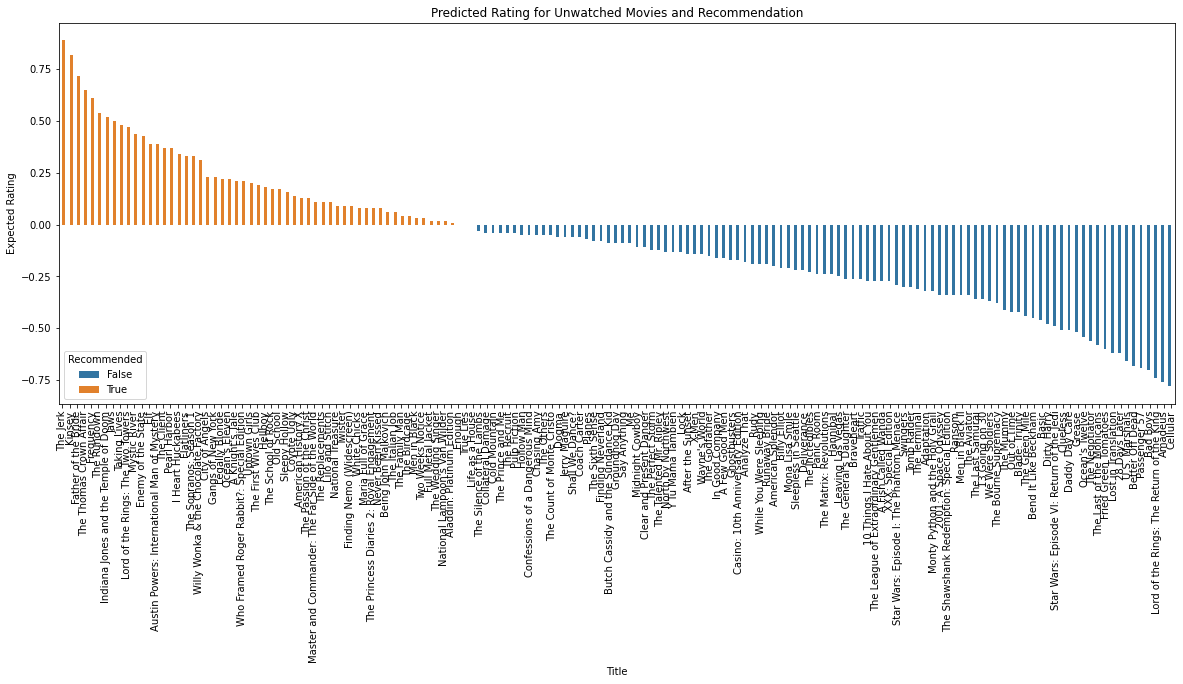

In [ ]:
res3 = get_similarity(175)

In [ ]:
res3[1]

,Title,Expected Rating,Recommended
82,The Jerk,0.89,True
87,Kinsey,0.82,True
131,Father of the Bride,0.72,True
110,The Thomas Crown Affair,0.65,True
77,Frequency,0.61,True
37,The Rundown,0.54,True
79,Indiana Jones and the Temple of Doom,0.52,True
7,Jaws,0.50,True
1,Taking Lives,0.48,True
78,Lord of the Rings: The Two Towers,0.47,True


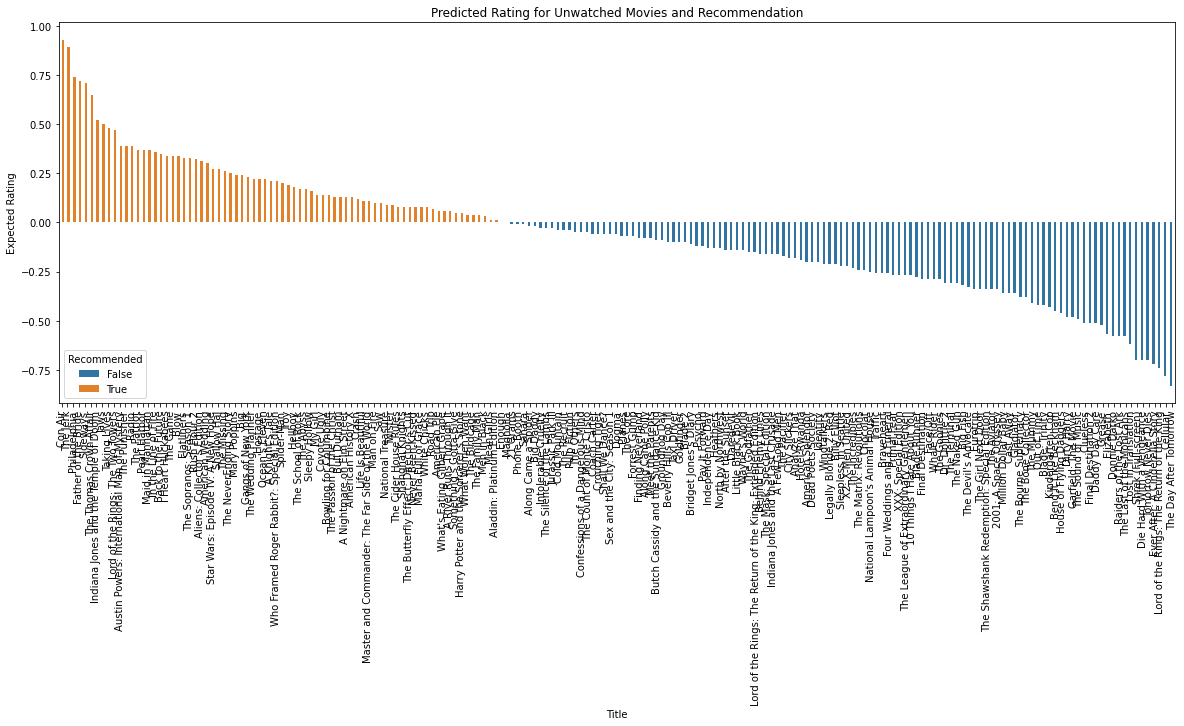

In [ ]:
res4 = get_similarity(440)

In [ ]:
res4[1]

,Title,Expected Rating,Recommended
161,Con Air,0.93,True
101,The Jerk,0.89,True
182,Philadelphia,0.74,True
159,Father of the Bride,0.72,True
41,Sideways,0.71,True
132,The Thomas Crown Affair,0.65,True
94,Indiana Jones and the Temple of Doom,0.52,True
13,Jaws,0.50,True
3,Taking Lives,0.48,True
91,Lord of the Rings: The Two Towers,0.47,True


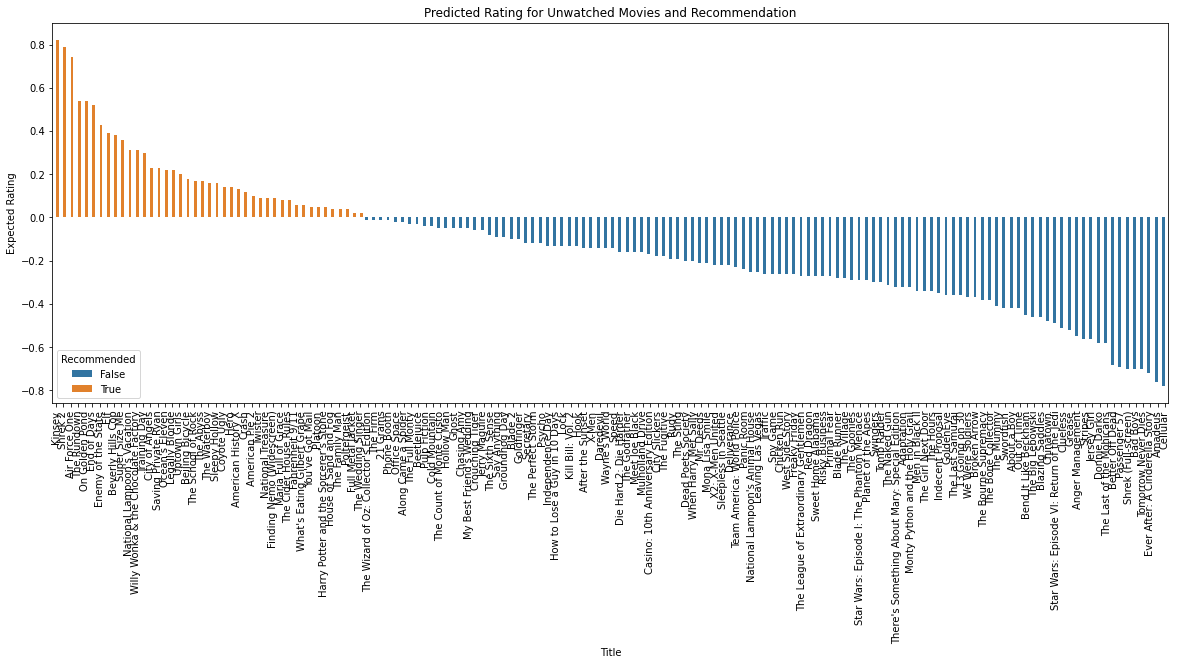

In [ ]:
res5 = get_similarity(999)

In [ ]:
res5[1]

,Title,Expected Rating,Recommended
90,Kinsey,0.82,True
43,Shrek 2,0.79,True
100,Air Force One,0.74,True
30,The Rundown,0.54,True
23,On Golden Pond,0.54,True
42,End of Days,0.52,True
104,Enemy of the State,0.43,True
29,Elf,0.39,True
17,Beverly Hills Cop,0.38,True
24,Super Size Me,0.36,True
